In [6]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import urllib.request
import sys
import fileinput  # Added for patching yamnet.py

# ==================== CONFIG ====================
SPLIT_ROOT = '../data/split_processed'
MODELS_DIR = '../models/models_approach2/yamnet_finetuned'
RESULTS_DIR = '../results/results_approach2/yamnet_finetuned'
YAMNET_DIR = './yamnet_source'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(YAMNET_DIR, exist_ok=True)

TARGET_SR = 16000
TARGET_SECONDS = 3
TARGET_LEN = TARGET_SR * TARGET_SECONDS

BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE_EARLY = 5
PATIENCE_LR = 3

tf.random.set_seed(42)
np.random.seed(42)

# ==================== DOWNLOAD YAMNET ====================
print("Ensuring YAMNet source files exist...")
for name, url in {
    'params.py': 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/params.py',
    'features.py': 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/features.py',
    'yamnet.py': 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet.py',
    'yamnet.h5': 'https://storage.googleapis.com/audioset/yamnet.h5'
}.items():
    path = os.path.join(YAMNET_DIR, name)
    if not os.path.exists(path):
        print(f"  downloading {name} ...")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"  {name} exists")

# ==================== PATCH YAMNET.PY ====================
# Fixes 'ModuleNotFoundError: No module named 'tf_keras'' by replacing imports
yamnet_py_path = os.path.join(YAMNET_DIR, 'yamnet.py')
with open(yamnet_py_path, 'r') as file:
    filedata = file.read()

# Replace tf_keras with tensorflow.keras to use existing TF installation
if 'from tf_keras' in filedata:
    print("Patching yamnet.py to use tensorflow.keras instead of tf_keras...")
    filedata = filedata.replace('from tf_keras', 'from tensorflow.keras')
    with open(yamnet_py_path, 'w') as file:
        file.write(filedata)

# ==================== IMPORT YAMNET ====================
if YAMNET_DIR not in sys.path:
    sys.path.insert(0, YAMNET_DIR)
if 'yamnet' in sys.modules: del sys.modules['yamnet']
if 'params' in sys.modules: del sys.modules['params']

import params as yamnet_params
import yamnet as yamnet_model
print("YAMNet module imported")

# ==================== DATA PREP ====================
CATEGORIES = ['alarm_clock','car_horn','glass_breaking','gunshot','siren', 'Background']
label_to_id = {'Alarm_Clock':0, 'Car_Horn':1, 'Glass_Breaking':2, 'Gunshot':3, 'Siren':4, 'Background':5}
# Normalize keys to match folder names if necessary
# Assuming folder names are lowercase snake_case based on your code (e.g., 'alarm_clock')

def get_files(split):
    paths, labels = [], []
    for c in CATEGORIES:
        folder = os.path.join(SPLIT_ROOT, split, c)
        if not os.path.exists(folder):
            continue
        for f in os.listdir(folder):
            if f.endswith('.npy'):
                paths.append(os.path.join(folder, f))
                # Map folder name back to ID. 
                # Your dict keys are Title Case (Alarm_Clock), folders are lowercase (alarm_clock).
                # Helper to match:
                key_match = c.title().replace(' ', '_') # basic attempt
                # Better approach: map via index in CATEGORIES
                if c in CATEGORIES:
                    labels.append(CATEGORIES.index(c))
                else:
                    labels.append(0)
    return paths, labels

train_paths, train_labels = get_files('train')
val_paths, val_labels = get_files('val')
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}")

# ==================== ROBUST LOADER ====================
def load_numpy_audio(path_bytes) -> np.ndarray:
    p = path_bytes.decode()
    arr = np.load(p).astype(np.float32)
    if np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype(np.float32) / 32768.0
    arr = np.squeeze(arr)
    if arr.ndim == 2:
        arr = np.mean(arr, axis=1 if arr.shape[1]==2 else 0)
    maxv = np.max(np.abs(arr)) if arr.size else 1.0
    if maxv > 0: arr = arr / max(1.0, maxv)
    return arr

def pad_or_trim_waveform(wave_np, target_len=TARGET_LEN, augment=False):
    length = wave_np.shape[0]
    if length < target_len:
        return np.pad(wave_np, (0, target_len - length), mode='constant')
    elif length > target_len:
        # Fixed logic: if augment is false, take center, else random crop
        start = np.random.randint(0, length - target_len + 1) if augment else (length - target_len) // 2
        return wave_np[start:start+target_len]
    return wave_np

@tf.function
def load_and_augment(path, label, augment):
    audio = tf.numpy_function(load_numpy_audio, [path], tf.float32)
    audio.set_shape([None])
    if tf.cast(augment, tf.bool):
        if tf.random.uniform([]) > 0.5: audio *= tf.random.uniform([], 0.7, 1.3)
        if tf.random.uniform([]) > 0.5: audio += tf.random.normal(tf.shape(audio), stddev=0.002)
        if tf.random.uniform([]) > 0.5:
            # Shift logic
            shift_amt = tf.cast(tf.random.uniform([], -0.1, 0.1) * tf.cast(tf.shape(audio)[0], tf.float32), tf.int32)
            audio = tf.roll(audio, shift_amt, axis=0)
    
    audio = tf.numpy_function(lambda a, aug: pad_or_trim_waveform(a, TARGET_LEN, bool(aug)), [audio, augment], tf.float32)
    audio.set_shape([TARGET_LEN])
    return audio, tf.cast(label, tf.int32)

def make_ds(paths, labels, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(len(paths), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, l: load_and_augment(p, l, tf.constant(augment)), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_labels, augment=True)
val_ds = make_ds(val_paths, val_labels, augment=False)

# ==================== MODEL ====================
params = yamnet_params.Params(sample_rate=TARGET_SR, patch_hop_seconds=0.48)
single_sample_base = yamnet_model.yamnet_frames_model(params)
single_sample_base.load_weights(os.path.join(YAMNET_DIR, 'yamnet.h5'))
print("Loaded YAMNet frames model.")

# Auto-detect embedding layer
embedding_layer = None
for layer in reversed(single_sample_base.layers):
    try: out_shape = layer.output_shape
    except: out_shape = None
    if out_shape and isinstance(out_shape, tuple) and out_shape[-1] == 1024:
        embedding_layer = layer
        break
if embedding_layer is None:
    embedding_layer = single_sample_base.layers[-2]
print("Embedding layer:", embedding_layer.name)

embed_model = tf.keras.Model(single_sample_base.input, embedding_layer.output)

# === FIX 1: FREEZE LOGIC APPLIED HERE ===
# We must freeze the base model layers *before* compilation
# By default freeze everything
single_sample_base.trainable = False
# Unfreeze the last few layers for fine-tuning
UNFREEZE_LAST = 8
# Note: single_sample_base is a functional model, iterating its layers works
base_layers = single_sample_base.layers
for layer in base_layers[-UNFREEZE_LAST:]:
    layer.trainable = True

print(f"Base model layers: {len(base_layers)}. Last {UNFREEZE_LAST} unfrozen.")

class YamnetEmbeddingLayer(tf.keras.layers.Layer):
    # === FIX 2: Correct __init__ syntax ===
    def __init__(self, embed_model, embedding_dim=1024, **kwargs):
        super().__init__(**kwargs)
        self.embed_model = embed_model
        self.embedding_dim = embedding_dim
        # No need for _output_spec in standard keras layers usually, but fine to keep

    def call(self, inputs):
        """
        inputs: [batch_size, waveform_len]
        """
        def single_forward(waveform):
            # waveform: [waveform_len] (1-D)
            # Yamnet expects a batch or single signal. 
            # If we pass 1D tensor to embed_model, it returns [frames, 1024]
            emb = self.embed_model(waveform)  
            if tf.rank(emb) == 2:
                emb = tf.reduce_mean(emb, axis=0)
            emb = tf.reshape(emb, (self.embedding_dim,))
            return emb

        # vectorized_map is safer than map_fn for gradients in some TF versions, 
        # but if it fails, switch to tf.map_fn
        embeddings = tf.vectorized_map(single_forward, inputs)
        embeddings.set_shape([None, self.embedding_dim]) 
        return embeddings

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.embedding_dim)

    def get_config(self):
        config = super().get_config()
        config.update({"embedding_dim": self.embedding_dim})
        return config

# Final model construction
wav_in = tf.keras.Input(shape=(TARGET_LEN,), dtype=tf.float32, name='waveform')
emb = YamnetEmbeddingLayer(embed_model)(wav_in)
x = tf.keras.layers.Dropout(0.3)(emb)
out = tf.keras.layers.Dense(len(CATEGORIES), activation='softmax')(x)
model = tf.keras.Model(inputs=wav_in, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

# ==================== TRAIN ====================
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=PATIENCE_LR),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODELS_DIR, 'best.keras'), save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.CSVLogger(os.path.join(RESULTS_DIR, 'log.csv'))
]

# Ensure datasets are not empty before fitting
if len(train_paths) > 0 and len(val_paths) > 0:
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)
    
    # ==================== RESULTS ====================
    model.save(os.path.join(MODELS_DIR, 'final_model.keras'))

    preds, true = [], []
    for x, y in val_ds:
        p = tf.argmax(model.predict(x, verbose=0), axis=1).numpy()
        preds.extend(p.tolist())
        true.extend(y.numpy().tolist())

    acc = np.mean(np.array(preds) == np.array(true))
    print(f"FINAL VALIDATION ACCURACY: {acc:.4f} ({acc*100:.2f}%)")

    # Plotting logic...
else:
    print("Error: No training data found. Check SPLIT_ROOT path.")

Ensuring YAMNet source files exist...
  params.py exists
  features.py exists
  yamnet.py exists
  yamnet.h5 exists
YAMNet module imported
Train: 5932, Val: 824
Loaded YAMNet frames model.
Embedding layer: global_average_pooling2d_1
Base model layers: 106. Last 8 unfrozen.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform (InputLayer)       [(None, 48000)]           0         
                                                                 
 yamnet_embedding_layer_1 (  (None, 1024)              3217344   
 YamnetEmbeddingLayer)                                           
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 6150      
                                                 

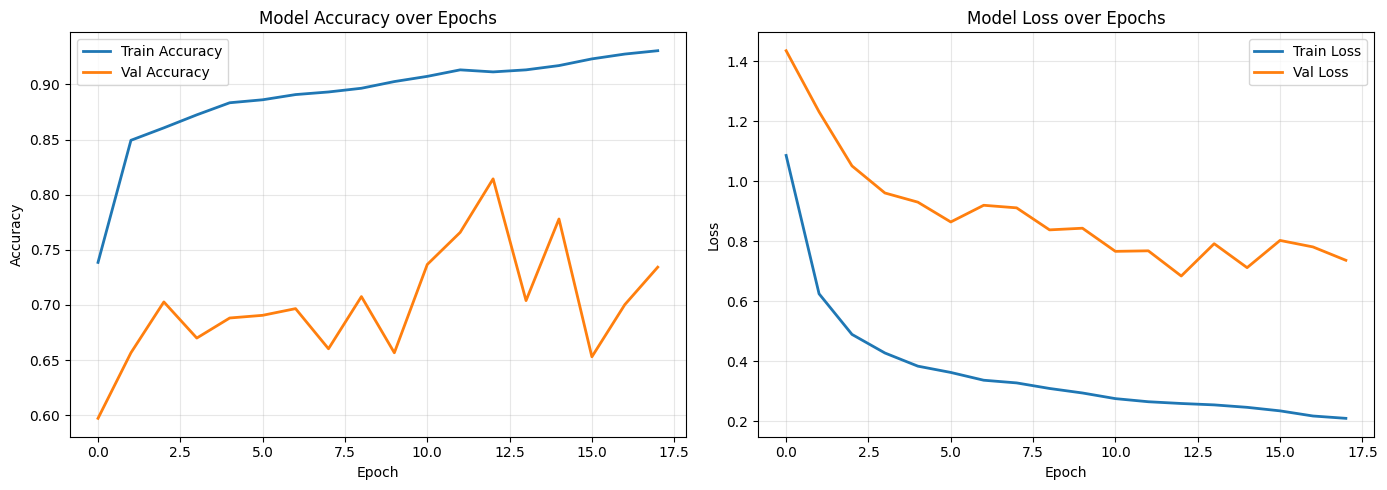

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import os

# CONFIG (Ensure these match your previous cell)
RESULTS_DIR = '../results/results_approach2/yamnet_finetuned'
CATEGORIES = ['alarm_clock','car_horn','glass_breaking','gunshot','siren', 'Background']

# 1. PLOT TRAINING CURVES (Load from CSV to be safe)
log_path = os.path.join(RESULTS_DIR, 'log.csv')

if os.path.exists(log_path):
    df = pd.read_csv(log_path)
    
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(df['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(df['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(df['loss'], label='Train Loss', linewidth=2)
    plt.plot(df['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Log file not found. Skipping curves.")


Loading weights from ../models/models_approach2/yamnet_finetuned\best.keras...
Generating predictions with clean model...
103/103 [==============================] - 12s 80ms/step


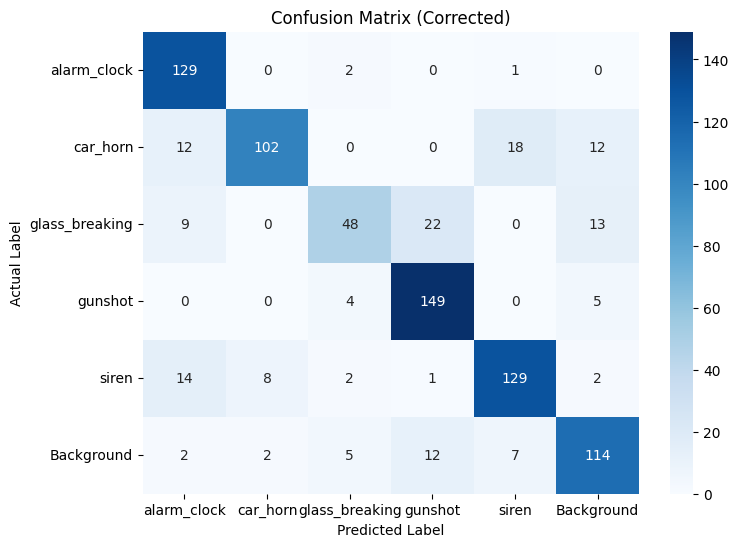


Classification Report:

                precision    recall  f1-score   support

   alarm_clock       0.78      0.98      0.87       132
      car_horn       0.91      0.71      0.80       144
glass_breaking       0.79      0.52      0.63        92
       gunshot       0.81      0.94      0.87       158
         siren       0.83      0.83      0.83       156
    Background       0.78      0.80      0.79       142

      accuracy                           0.81       824
     macro avg       0.82      0.80      0.80       824
  weighted avg       0.82      0.81      0.81       824

FINAL VALIDATION ACCURACY: 0.8143 (81.43%)


In [21]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ==================== 1. CONFIG ====================
MODELS_DIR = '../models/models_approach2/yamnet_finetuned'
WEIGHTS_PATH = os.path.join(MODELS_DIR, 'best.keras')  # Loading the best weights
CATEGORIES = ['alarm_clock','car_horn','glass_breaking','gunshot','siren', 'Background']

# ==================== 2. REBUILD CLEAN MODEL ====================
# We re-define the layer and model to clear any "Graph Error" state from TFLite attempts

# A. Re-define the Custom Layer
class YamnetEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, embed_model, embedding_dim=1024, **kwargs):
        super().__init__(**kwargs)
        self.embed_model = embed_model
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        def single_forward(waveform):
            emb = self.embed_model(waveform)  
            if tf.rank(emb) == 2:
                emb = tf.reduce_mean(emb, axis=0)
            emb = tf.reshape(emb, (self.embedding_dim,))
            return emb
        
        # This map function is what usually breaks after TFLite conversion attempts
        embeddings = tf.vectorized_map(single_forward, inputs)
        embeddings.set_shape([None, self.embedding_dim]) 
        return embeddings

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.embedding_dim)

# B. Get the YAMNet Base (Embed Model)
# We assume 'single_sample_base' exists from your earlier cells. 
# If not, we quickly grab the layer from the saved file structure or memory.
if 'single_sample_base' in globals():
    # Use existing base in memory
    embedding_layer = single_sample_base.layers[-2] # Approx location
    # Safety check for the right layer
    for layer in reversed(single_sample_base.layers):
        if hasattr(layer, 'output_shape') and layer.output_shape[-1] == 1024:
            embedding_layer = layer
            break
    embed_model = tf.keras.Model(single_sample_base.input, embedding_layer.output)
else:
    raise ValueError("Please run the YAMNet setup cell (IMPORT YAMNET) first to load 'single_sample_base'.")

# C. Re-instantiate the Architecture
wav_in = tf.keras.Input(shape=(48000,), dtype=tf.float32, name='waveform')
emb = YamnetEmbeddingLayer(embed_model)(wav_in)
x = tf.keras.layers.Dropout(0.3)(emb)
out = tf.keras.layers.Dense(len(CATEGORIES), activation='softmax')(x)
clean_model = tf.keras.Model(inputs=wav_in, outputs=out)

# D. Load Weights
print(f"Loading weights from {WEIGHTS_PATH}...")
clean_model.load_weights(WEIGHTS_PATH)

# ==================== 3. PREDICT & PLOT ====================
print("Generating predictions with clean model...")

# Ensure val_ds_clean exists (from your previous code)
if 'val_ds_clean' not in globals():
    print("Re-creating val_ds_clean...")
    val_ds_clean = make_ds(val_paths, val_labels, augment=False, shuffle=False)

y_pred_probs = clean_model.predict(val_ds_clean, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels
y_true = []
for _, label in val_ds_clean:
    y_true.extend(label.numpy())
y_true = np.array(y_true)

# Plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix (Corrected)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

acc = np.mean(y_true == y_pred)
print(f"FINAL VALIDATION ACCURACY: {acc:.4f} ({acc*100:.2f}%)")

In [23]:
import tensorflow as tf
import os

# ==================== CONFIG ====================
MODELS_DIR = '../models/models_approach2/yamnet_finetuned'
TFLITE_PATH = os.path.join(MODELS_DIR, 'sound_classifier.tflite')
TARGET_LEN = 48000

# ==================== 1. PREPARE LAYERS ====================
# Extract the internal YAMNet and Dense layers from your active model
trained_yamnet = model.layers[1].embed_model 
trained_dense = model.layers[-1]

# ==================== 2. DEFINE TF MODULE ====================
# We use a raw tf.Module instead of a Keras Model.
# This gives us manual control over shapes inside the graph.

class SoundClassifierModule(tf.Module):
    def __init__(self, feature_extractor, classifier):
        super(SoundClassifierModule, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    # We define the specific signature TFLite needs: [1, 48000]
    @tf.function(input_signature=[tf.TensorSpec(shape=[1, TARGET_LEN], dtype=tf.float32)])
    def __call__(self, input_tensor):
        """
        input_tensor: (1, 48000) -> The shape TFLite expects.
        """
        
        # 1. SQUEEZE: Remove batch dim for YAMNet
        # YAMNet internals expect (48000,) not (1, 48000)
        waveform_1d = tf.squeeze(input_tensor, axis=0) 
        
        # 2. EXTRACT FEATURES
        # Output shape: (Frames, 1024)
        embeddings = self.feature_extractor(waveform_1d)
        
        # 3. POOLING: Average over time frames
        # Output shape: (1024,)
        # Note: If embeddings is 2D (Frames, Features), we reduce axis 0
        embedding_mean = tf.reduce_mean(embeddings, axis=0)
        
        # 4. RESHAPE: Add batch dim back for Dense Layer
        # Dense layer expects (Batch, Features) -> (1, 1024)
        embedding_batch = tf.expand_dims(embedding_mean, axis=0)
        
        # 5. CLASSIFY
        # Output shape: (1, Num_Classes)
        output = self.classifier(embedding_batch)
        
        return {'outputs': output}

# Instantiate the module
inference_module = SoundClassifierModule(trained_yamnet, trained_dense)

print("Inference Module created. Converting...")

# ==================== 3. CONVERT TO TFLITE ====================
# We convert the concrete function, not the Keras model
concrete_func = inference_module.__call__.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func], inference_module)

# Enable Audio Ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model_binary = converter.convert()

# Save
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model_binary)

print(f"Success! Model saved to: {TFLITE_PATH}")
print(f"Size: {len(tflite_model_binary) / 1024 / 1024:.2f} MB")

Inference Module created. Converting...
Success! Model saved to: ../models/models_approach2/yamnet_finetuned\sound_classifier.tflite
Size: 12.30 MB


In [24]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"\nExpected Input: {input_details[0]['shape']}")
# Should be [1, 48000]

# Dummy Inference
dummy_data = np.zeros((1, 48000), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], dummy_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"Output Shape: {output_data.shape}")
print(f"Prediction: {output_data[0]}")


Expected Input: [    1 48000]
Output Shape: (1, 6)
Prediction: [0.21127851 0.07501671 0.11318016 0.09203023 0.25277662 0.2557177 ]


Evaluating TFLite model on 824 files...
Model Input Shape: [    1 48000]
Processed 100/824
Processed 200/824
Processed 300/824
Processed 400/824
Processed 500/824
Processed 600/824
Processed 700/824
Processed 800/824

Inference finished in 15.21 seconds.
Average time per sample: 18.46 ms

TFLITE TEST ACCURACY: 0.8313 (83.13%)


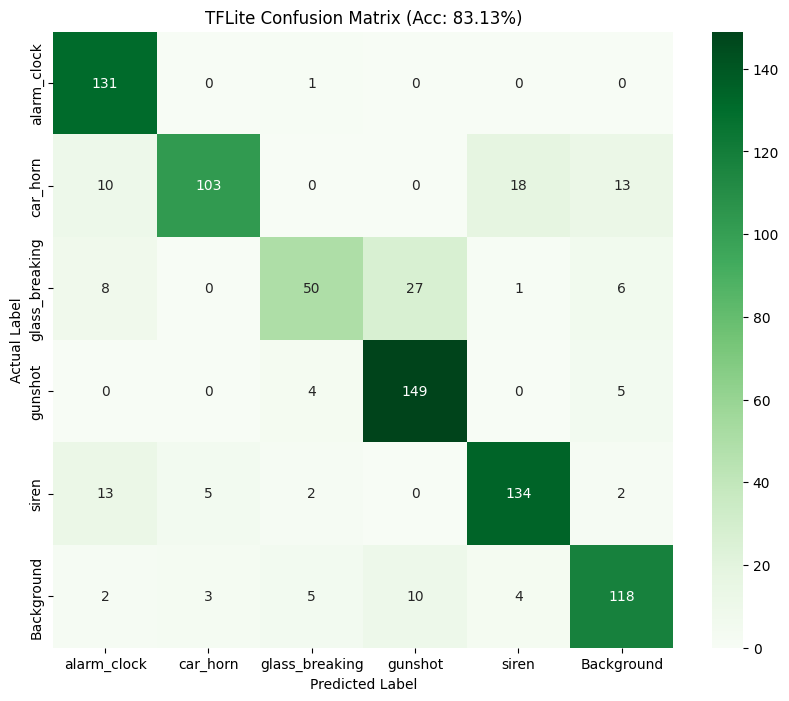


--- TFLite Classification Report ---
                precision    recall  f1-score   support

   alarm_clock       0.80      0.99      0.89       132
      car_horn       0.93      0.72      0.81       144
glass_breaking       0.81      0.54      0.65        92
       gunshot       0.80      0.94      0.87       158
         siren       0.85      0.86      0.86       156
    Background       0.82      0.83      0.83       142

      accuracy                           0.83       824
     macro avg       0.83      0.81      0.82       824
  weighted avg       0.84      0.83      0.83       824



In [25]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

# ==================== CONFIG ====================
TFLITE_PATH = '../models/models_approach2/yamnet_finetuned/sound_classifier.tflite'
TARGET_LEN = 48000
CATEGORIES = ['alarm_clock','car_horn','glass_breaking','gunshot','siren', 'Background']

# Reuse validation data (or replace with test_paths/test_labels if you have a separate split)
# ensuring these variables exist from previous cells
TEST_FILES = val_paths 
TEST_LABELS = val_labels

print(f"Evaluating TFLite model on {len(TEST_FILES)} files...")

# ==================== 1. SETUP INTERPRETER ====================
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_index = input_details[0]['index']
output_index = output_details[0]['index']

print(f"Model Input Shape: {input_details[0]['shape']}")

# ==================== 2. PREPROCESSING HELPER ====================
def preprocess_for_tflite(file_path):
    """
    Loads .npy file, normalizes, pads/crops to 48000, 
    and reshapes to [1, 48000] for TFLite.
    """
    # Load
    wav = np.load(file_path).astype(np.float32)
    
    # Handle int16 vs float
    if np.issubdtype(wav.dtype, np.integer):
        wav = wav / 32768.0
        
    # Flatten/Mono
    wav = np.squeeze(wav)
    if wav.ndim == 2:
        wav = np.mean(wav, axis=1) # mix to mono if stereo
        
    # Normalize Volume
    maxv = np.max(np.abs(wav)) if wav.size > 0 else 1.0
    if maxv > 0: 
        wav = wav / maxv
        
    # Pad or Center Crop to 48000
    if len(wav) < TARGET_LEN:
        wav = np.pad(wav, (0, TARGET_LEN - len(wav)), 'constant')
    else:
        start = (len(wav) - TARGET_LEN) // 2
        wav = wav[start:start+TARGET_LEN]
        
    # Add Batch Dimension: [1, 48000]
    return wav.reshape(1, TARGET_LEN)

# ==================== 3. RUN INFERENCE LOOP ====================
y_pred = []
y_true = []

start_time = time.time()

for i, (path, label) in enumerate(zip(TEST_FILES, TEST_LABELS)):
    # 1. Prepare Input
    input_data = preprocess_for_tflite(path)
    
    # 2. Set Tensor
    interpreter.set_tensor(input_index, input_data)
    
    # 3. Run Inference
    interpreter.invoke()
    
    # 4. Get Result
    output_data = interpreter.get_tensor(output_index)
    prediction = np.argmax(output_data) # Index of highest probability
    
    y_pred.append(prediction)
    y_true.append(label)
    
    # Optional: Print progress every 100 files
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(TEST_FILES)}")

total_time = time.time() - start_time
print(f"\nInference finished in {total_time:.2f} seconds.")
print(f"Average time per sample: {total_time/len(TEST_FILES)*1000:.2f} ms")

# ==================== 4. METRICS & PLOTTING ====================
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
acc = np.mean(y_true == y_pred)
print(f"\nTFLITE TEST ACCURACY: {acc:.4f} ({acc*100:.2f}%)")

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title(f'TFLite Confusion Matrix (Acc: {acc:.2%})')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Detailed Report
print("\n--- TFLite Classification Report ---")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))